In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [45]:
from setup import model_dir, image_dir, out_dir, data_dir
from util_model import parse_args

zoomlevel = 'zoom15'
latent_dim = 100
demo_dim = 5
# demo_cols = [0,1,2,3,4,8,9]
# demo_cols = [0,9]
image_size = str(128)
im_norm = '2'
model_run_date = "2211-3-7-128"
model_type = 'dcgan'
loss_func = 'mse'
model_class = 'clf'
base_lr = '0.0001'
weight_decay = '0.0005'
sampling = 'clustered'

args = parse_args(s=['--zoomlevel', zoomlevel, '--latent_dim', str(latent_dim), 
                     '--image_size', image_size, \
                     '--im_norm', im_norm, '--model_run_date', model_run_date, '--model_type', model_type, \
                     '--loss_func', loss_func, '--model_class', model_class, \
                     '--base_lr', base_lr, '--weight_decay', weight_decay, \
                     '--demo_channels', str(demo_dim), \
                     '--sampling', sampling])

from util_model import dcgan_config, load_model

config = dcgan_config(args)

run_config = config['run_config']
optim_config = config['optim_config']
data_config = config['data_config']
model_config = config['model_config']
run_config['tensorboard'] = False

# enc = load_model('dcgan', 'Discriminator', config)
# enc = enc.to(device)

# config['encoder'] = enc
# clf = load_model('direct_regression', "DirectRegression", config)
clf = load_model('mobilenet', 'MobileNetV2', config)
clf = clf.to(device)


In [4]:
from dataloader import image_loader

# Satellite
train_loader, test_loader = image_loader(image_dir+args.zoomlevel+"/", data_dir, optim_config['batch_size'], 
         run_config['num_workers'], 
         data_config['image_size'], 
         data_version=args.data_version, 
         sampling=args.sampling, 
         recalculate_normalize=False,
         augment=False,
         norm=args.im_norm,
         demo=True)

28280 images in dataset
3140 images in dataset


In [42]:
import torch
import torch.nn as nn
criterion = nn.BCELoss(reduction='mean')


In [46]:
optim = torch.optim.Adam(clf.parameters(), lr=optim_config['base_lr'], weight_decay=optim_config['weight_decay'])


In [47]:
import glob
import numpy as np
import os


ref1 = 0
ref2 = 0

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

train_flag = True
    
for epoch in range(optim_config['epochs']):
    
    clf.train()
    loss_ = 0
    train_acc = torch.zeros(5,)
    
    for step, (image_list, data, demo) in enumerate(train_loader):
        
        optim.zero_grad()
        
        data = data.to(device)
        demo = demo.float().to(device)
        out_demo = clf(data)
            
        loss = criterion(out_demo, demo)
        loss.backward()

        optim.step()
        
        loss_ += loss.detach()
        train_acc += torch.sum((out_demo > 0.5).float() == demo, dim=0).detach().cpu().numpy()
        
    loss_ = loss.cpu().detach().numpy()
    train_loss_list.append(loss_/step)
    
    print("[Train] Epoch %d: %.4E" % (epoch, loss_/step))
    print(train_acc / 28280)
    
    if epoch % 5 == 0:
        
        clf.eval()

        loss_ = 0
        test_acc = torch.zeros(5,)
        
        for step, (image_list, data, demo) in enumerate(test_loader):

            data = data.to(device)
            demo = demo.float().to(device)
    
            out_demo = clf(data)
            loss = criterion(out_demo, demo)
            loss_ += loss.detach()
            test_acc += torch.sum((out_demo > 0.5).float() == demo, dim=0).detach().cpu().numpy()

        loss_ = loss.cpu().detach().numpy()
        test_loss_list.append(loss_/step) 
        
        print("[Test] Epoch %d: %.4E" % (epoch, loss_/step))
        print(test_acc/3140)
        print()
    
        if epoch > 30:
            if (np.abs(loss_ - ref1)<ref1*0.001) & (np.abs(loss_ - ref2)<ref2*0.001):
                print("Early stopping at epoch", epoch)
                break
            if (ref1 < loss_) & (ref1 < ref2):
                print("Diverging. stop.")
                train_flag = False
                break
            if loss_ < best:
                best = loss_
                best_epoch = epoch
        else:
            best = loss_
            best_epoch = epoch

        ref2 = ref1
        ref1 = loss_

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': clf.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'config': config},
                model_dir+"CLF_"+str(model_run_date)+"_"+str(epoch)+".pt")

            
if config['run_config']['save']:
    files = glob.glob(model_dir+"CLF_"+str(model_run_date)+"_*.pt")

    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)

[Train] Epoch 0: 1.1079E-03
tensor([0.6091, 0.8320, 0.8105, 0.8008, 0.6366], dtype=torch.float64)
[Test] Epoch 0: 5.8962E-03
tensor([0.6293, 0.8449, 0.8478, 0.7943, 0.6653], dtype=torch.float64)

[Train] Epoch 1: 1.1268E-03
tensor([0.6651, 0.8810, 0.8143, 0.8227, 0.6871], dtype=torch.float64)
[Train] Epoch 2: 1.0355E-03
tensor([0.6926, 0.8902, 0.8145, 0.8309, 0.7105], dtype=torch.float64)
[Train] Epoch 3: 9.7403E-04
tensor([0.7076, 0.8953, 0.8147, 0.8366, 0.7244], dtype=torch.float64)
[Train] Epoch 4: 9.1985E-04
tensor([0.7207, 0.8976, 0.8142, 0.8397, 0.7355], dtype=torch.float64)
[Train] Epoch 5: 8.7364E-04
tensor([0.7351, 0.9002, 0.8150, 0.8428, 0.7494], dtype=torch.float64)
[Test] Epoch 5: 5.3602E-03
tensor([0.6707, 0.8717, 0.8446, 0.8127, 0.6736], dtype=torch.float64)

[Train] Epoch 6: 1.0147E-03
tensor([0.7523, 0.9040, 0.8149, 0.8479, 0.7663], dtype=torch.float64)
[Train] Epoch 7: 1.0374E-03
tensor([0.7661, 0.9054, 0.8164, 0.8492, 0.7803], dtype=torch.float64)
[Train] Epoch 8: 8.0

In [30]:
test_out = []
test_true = []

for step, (image_list, data, demo) in enumerate(test_loader):
    
    test_true.append(demo[:, demo_cols])
    data = data.to(device)
    demo = demo[:, demo_cols].to(device)

    out_demo = clf(data)
    out_demo = out_demo.detach().cpu().numpy()
    test_out.append(out_demo)


test_out = np.concatenate(test_out)
test_true = np.concatenate(test_true)

test_err = test_out - test_true

In [23]:
train_out = []
train_true = []

for step, (image_list, data, demo) in enumerate(train_loader):
    
    train_true.append(demo[:, demo_cols])
    data = data.to(device)
    demo = demo[:, demo_cols].to(device)

    out_demo = clf(data)
    out_demo = out_demo.detach().cpu().numpy()
    train_out.append(out_demo)


train_out = np.concatenate(train_out)
train_true = np.concatenate(train_true)

train_err = train_out - train_true

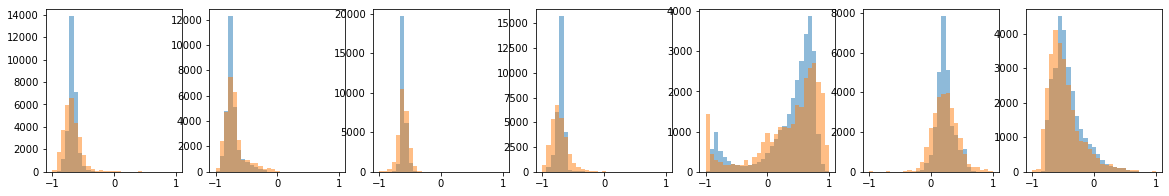

In [27]:
import matplotlib.pyplot as plt

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(1,7, figsize=(20,3))
for i in range(7):
    ax[i].hist(train_out[:,i], bins=bins, alpha=0.5)
    ax[i].hist(train_true[:,i], bins=bins, alpha=0.5)

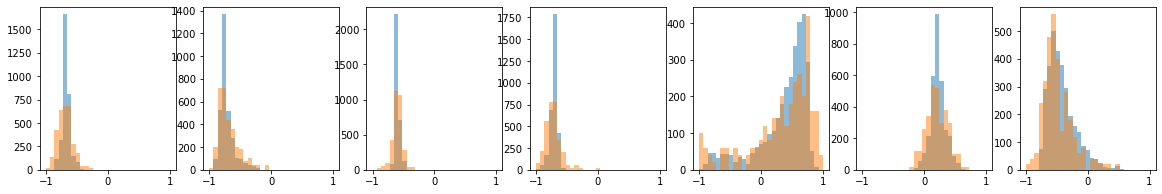

In [28]:
bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(1,7, figsize=(20,3))
for i in range(7):
    ax[i].hist(test_out[:,i], bins=bins, alpha=0.5)
    ax[i].hist(test_true[:,i], bins=bins, alpha=0.5)

In [31]:
mae = np.mean(np.abs(test_err), axis=0)

In [32]:
mae

array([0.09598063, 0.08465722, 0.05994426, 0.08850216, 0.25618732,
       0.12319178, 0.14114317], dtype=float32)

In [33]:
rmse = np.mean(test_err**2, axis=0)

In [34]:
rmse

array([0.01438137, 0.01278775, 0.00602057, 0.01498648, 0.12328903,
       0.02607518, 0.03483103], dtype=float32)